# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

## Problem Statement

This project is to build model to predict how the customer will respond to given offer based on demographics and offer type.Also will do data analysis and answer below questions:<br>
1. What is the most and least successfull offer by calculating the success rate?<br>
2. What is the number of customer provided with specific offer?<br>

## Strategy

I'll follow the following steps to solve the problem. First, Explore portfolio, profile, transcript datasets , clean them, then combine them. Each row in the combined dataset will have offers attributes, customer demographic data and offer is successful or not. Second,Assess the accuracy and F1 score of a naive model which assumes that all offer were sucessful.Then compare the performance of logistic regression and random forest models.

## Metrics

I'll evaluate model performance by using accuracy and F1 score metrics. Accuracy will measure how well a model correctly predicts wether the offer is successful. However, if the percentage of successful or unsuccessful offers is ver low, accuracy is not a good measure of model performance because of this I'll use also F1 score metric because it's a weighted average of the precision and recall metrics.

In [1]:
import pandas as pd
import numpy as np
import math
import json
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import pickle
import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import  fbeta_score,make_scorer , accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import  RandomizedSearchCV
from sklearn.linear_model import LogisticRegression



# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
from sklearn.pipeline import Pipeline

## Data Exploration & Visualization

### portfolio

In [3]:
### get an idea about portfolio data
portfolio.head(10)

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [4]:
#shape of portfolio
portfolio.shape

(10, 6)

In [5]:
#get portfolio info
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [6]:
portfolio.describe()

,reward,difficulty,duration
count,10.000000,10.000000,10.000000
mean,4.200000,7.700000,6.500000
std,3.583915,5.831905,2.321398
min,0.000000,0.000000,3.000000
25%,2.000000,5.000000,5.000000
50%,4.000000,8.500000,7.000000
75%,5.000000,10.000000,7.000000
max,10.000000,20.000000,10.000000


In [7]:
#check how many channel do we've
portfolio.offer_type.unique()

array(['bogo', 'informational', 'discount'], dtype=object)

In [8]:
#create hist_plot function 
def hist_plot(data,title,xlabel,ylabel,v_range=(0,0)):
    '''
    this function to plot the histogram
    
    input: column data, title of graoh, xlabel & ylabel
    '''
    if v_range==(0,0):
        plt.hist(data)
    else:
        plt.hist(data,range=v_range)
   
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show


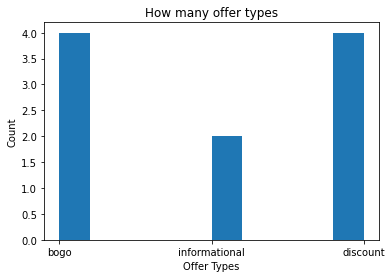

In [9]:
hist_plot(portfolio['offer_type'],'How many offer types','Offer Types','Count')

Text(0, 0.5, 'Count')

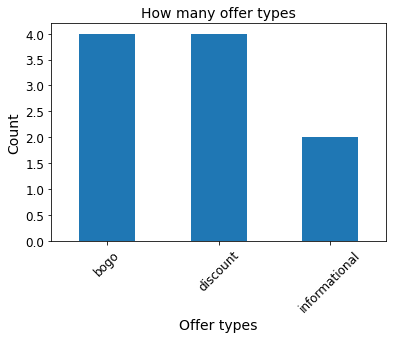

In [10]:

#plot the offer type
ax=portfolio['offer_type'].value_counts().plot.bar(rot=45,fontsize=12)
ax.set_title('How many offer types',fontsize=14) #set plot title
ax.set_xlabel('Offer types',fontsize=14)#set x label
ax.set_ylabel('Count',fontsize=14) #set y label

portfolio has 10 rows and 6 columns and there is no null values, it has web, email, mobile, social channels where offers are deployed , chnnels column need to be cleaned. also we've 3 offer types bogo,discount and informational.

### profile

In [11]:
#get an idea about profile data
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [12]:
#get profile shape
profile.shape

(17000, 5)

In [13]:
#get profile info
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [14]:
#get describe
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [15]:
#check unique values of gender
profile.gender.unique()

array([None, 'F', 'M', 'O'], dtype=object)

In [16]:
# check unique value of age
profile.age.unique()

array([118,  55,  75,  68,  65,  58,  61,  26,  62,  49,  57,  40,  64,
        78,  42,  56,  33,  46,  59,  67,  53,  22,  96,  69,  20,  45,
        54,  39,  41,  79,  66,  29,  44,  63,  36,  76,  77,  30,  51,
        27,  73,  74,  70,  89,  50,  90,  60,  19,  72,  52,  18,  71,
        83,  43,  47,  32,  38,  34,  85,  48,  35,  82,  21,  24,  81,
        25,  37,  23, 100,  28,  84,  80,  87,  86,  94,  31,  88,  95,
        93,  91,  92,  98, 101,  97,  99])

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='gender', ylabel='count'>

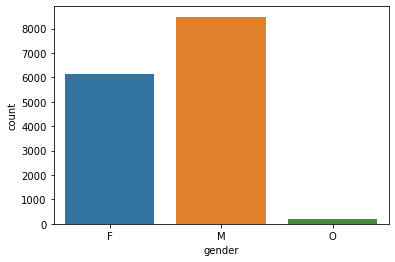

In [17]:
#gender Distribution 
sns.countplot(profile['gender'])

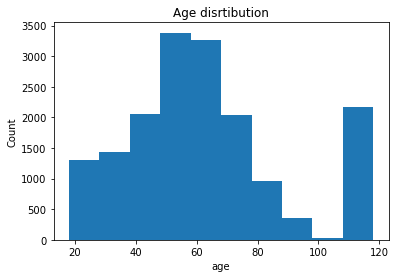

In [18]:

#plot age histogram
hist_plot(profile['age'],'Age disrtibution','age','Count')

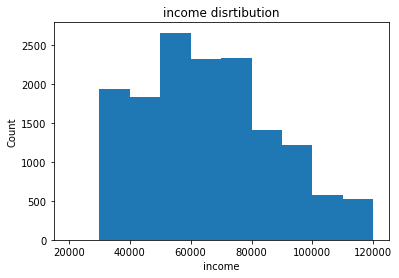

In [19]:
#plot income Distribution 
hist_plot(profile['income'],'income disrtibution','income','Count',(20000,120000))

From above, profile dataset has 17000 rows and 5 columns,there is null values in gender and income columns. from the above Distribution of gender that male is more than female, and from age Distribution the age group 50,60 are the highest. from income distribution member with income range from 50k-80k are higher than others.
this data set need to be cleaned since we've null values and age value of 118 seems to be data entry error.

### transcript

In [20]:
#get an idea how transcript data is look like
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [21]:
#get the shape of transcript
transcript.shape

(306534, 4)

In [22]:
#get info of transcript
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


## Data Wrangling

In [23]:
#Function to check null values
def check_null(df,name):
    ''''
    this function to check null values in df
    
    input: dataset df
    '''
    df.name=name
    print('Null in ',df.name)
    size=len(df)
    for col in df.columns:
        null_count=df[col].isnull().sum()
        print('{} has {} % null values'.format(col,(null_count/size)*100))
    

In [24]:
#function to check duplicate values
def check_duplicate(df,name):
    df.name=name
    print('duplicates in ',df.name)
    for col in df.columns: 
        #make sure that column type is not list or dict to find duplicates
        if type(df[col][0]) is not list and type(df[col][0]) is not dict:
            print('{} duplicates {}'.format(col,df.duplicated(col).sum()))

In [25]:
#check null values in portfolio
check_null(portfolio,'portfolio')

Null in  portfolio
reward has 0.0 % null values
channels has 0.0 % null values
difficulty has 0.0 % null values
duration has 0.0 % null values
offer_type has 0.0 % null values
id has 0.0 % null values


There is no null value in portfolio

In [26]:
# check duplicates value in portfolio
check_duplicate(portfolio,'portfolio')

duplicates in  portfolio
reward duplicates 5
difficulty duplicates 5
duration duplicates 5
offer_type duplicates 7
id duplicates 0


In [27]:
#check null value in profile
check_null(profile,'profile')

Null in  profile
gender has 12.794117647058822 % null values
age has 0.0 % null values
id has 0.0 % null values
became_member_on has 0.0 % null values
income has 12.794117647058822 % null values


gender & income has around 12% null value, since the percentage is small then we can remove null rows

In [28]:
# check duplicates value in portfolio
check_duplicate(profile,'profile')

duplicates in  profile
gender duplicates 16996
age duplicates 16915
id duplicates 0
became_member_on duplicates 15284
income duplicates 16908


In [29]:
#check number of unique ids
profile.id.nunique()

17000

id is the key column and there is no duplicate in id

In [30]:
#check null value in transcript
check_null(transcript,'transcript')

Null in  transcript
person has 0.0 % null values
event has 0.0 % null values
value has 0.0 % null values
time has 0.0 % null values


there is no null values in transcript

In [31]:
#check duplicates value in transcript columns
check_duplicate(transcript,'transcript')

duplicates in  transcript
person duplicates 289534
event duplicates 306530
time duplicates 306414


In [32]:
#check number of unique person
transcript.person.nunique()

17000

In profile we've 17000 ids and same number of person on transcript

### Clean data

In [33]:
#make copy of all dataframes in order to clean them
profile_clean=profile
portfolio_clean=portfolio
transcript_clean=transcript

In [34]:
profile_clean=profile

### 1. profile data

◼ rename id column to member_id <br>
◼ change age value 118 to NaN <br>
◼ change became_member_on type to date<br>
◼ drop rows with null values (age , gender and income)<br>
◼ convert gender value to 0 and 1<br>
◼ define start_year, start_month columns from became_member_on <br>

In [35]:
# rename id column in profile to member_id
profile_clean=profile_clean.rename(columns={'id':'member_id'})

In [36]:
#make sure column name is changed
profile_clean.columns

Index(['gender', 'age', 'member_id', 'became_member_on', 'income'], dtype='object')

In [37]:
#check rows where age =118
profile_clean.where(profile_clean.age==118).count()

gender                 0
age                 2175
member_id           2175
became_member_on    2175
income                 0
dtype: int64

In [38]:
#change age value 118 to Nan
profile_clean.age.replace(118,np.nan,inplace=True)

In [39]:
#make sure age value 118 replaced with NaN
profile_clean.where(profile_clean.age==118).count()

gender              0
age                 0
member_id           0
became_member_on    0
income              0
dtype: int64

In [40]:
#change type of became_member_on
profile_clean.became_member_on=profile_clean['became_member_on'].astype(str).astype('datetime64[ns]')

In [41]:
# make sure type of became_member_on is changed
profile_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   gender            14825 non-null  object        
 1   age               14825 non-null  float64       
 2   member_id         17000 non-null  object        
 3   became_member_on  17000 non-null  datetime64[ns]
 4   income            14825 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 664.2+ KB


In [42]:
print(len(profile_clean[profile_clean['gender'].isnull()]),len(profile_clean[profile_clean['age'].isnull()]),len(profile_clean[profile_clean['income'].isnull()]))

2175 2175 2175


In [43]:
#drop rows with null values of gender,age and income
profile_clean=profile_clean.drop(profile_clean[profile_clean['gender'].isnull()].index)

In [44]:
#make sure rows with null values of gender,age and income are removed
print(len(profile_clean[profile_clean['gender'].isnull()]),len(profile_clean[profile_clean['age'].isnull()]),len(profile_clean[profile_clean['income'].isnull()]))

0 0 0


In [45]:
# Convert gender values to numeric 0s and 1s
profile_clean['gender'] = profile_clean['gender'].apply(lambda x: 1 if x == 'M' else 0)

In [46]:
profile_clean.gender.unique()

array([0, 1])

In [47]:
gender_mapping=['F','M']

In [48]:
# profile: add start_year column
profile_clean['start_year'] = profile_clean.became_member_on.dt.year
profile_clean["start_month"] = profile_clean.became_member_on.dt.month

In [49]:
profile_clean

,gender,age,member_id,became_member_on,income,start_year,start_month
1,0,55.0,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,7
3,0,75.0,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017,5
5,1,68.0,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,2018,4
8,1,65.0,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,2018,2
12,1,58.0,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,2017,11
...,...,...,...,...,...,...,...
16995,0,45.0,6d5f3a774f3d4714ab0c092238f3a1d7,2018-06-04,54000.0,2018,6
16996,1,61.0,2cb4f97358b841b9a9773a7aa05a9d77,2018-07-13,72000.0,2018,7
16997,1,49.0,01d26f638c274aa0b965d24cefe3183f,2017-01-26,73000.0,2017,1
16998,0,83.0,9dc1421481194dcd9400aec7c9ae6366,2016-03-07,50000.0,2016,3


### 2. portfolio data

◼ rename id column to offer_id<br>
◼ one-hot encode channels <br>
◼ one-hot encode offer_type <br>

In [50]:
#rename id column to offer_id
portfolio_clean=portfolio_clean.rename(columns={'id':'offer_id'})

In [51]:
#make sure column name is changed
portfolio_clean.columns

Index(['reward', 'channels', 'difficulty', 'duration', 'offer_type',
       'offer_id'],
      dtype='object')

In [52]:
def one_hot_encode(df,col_list,col):
    ''''
    this function to one hot encode column
    
    input: df, column list and column need to apply one-hot encode
    output: df with multi columns
    '''
    for index,row in df.iterrows():
        for new_col in col_list:
            if new_col in df.loc[index,col]:
                df.loc[index,new_col]=1
            else:
                df.loc[index,new_col]=0
    return df


In [53]:
#one-hot encode channels
channel_list=['web','email','social','mobile']
portfolio_clean=one_hot_encode(portfolio_clean,channel_list,'channels')

In [54]:
#check the one-hoe encode
portfolio_clean

,reward,channels,difficulty,duration,offer_type,offer_id,web,email,social,mobile
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0.0,1.0,1.0,1.0
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1.0,1.0,1.0,1.0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,1.0,1.0,0.0,1.0
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.0,1.0,0.0,1.0
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1.0,1.0,0.0,0.0
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1.0,1.0,1.0,1.0
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1.0,1.0,1.0,1.0
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837,0.0,1.0,1.0,1.0
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1.0,1.0,1.0,1.0
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5,1.0,1.0,0.0,1.0


In [55]:
#remove channels column
portfolio_clean.drop(columns='channels',inplace=True)

In [56]:
#one-hot encode offer_type
offer_list=['bogo','informational','discount']
portfolio_clean=one_hot_encode(portfolio_clean,offer_list,'offer_type')

In [57]:
#check the one-hoe encode
portfolio_clean

,reward,difficulty,duration,offer_type,offer_id,web,email,social,mobile,bogo,informational,discount
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0.0,1.0,1.0,1.0,1.0,0.0,0.0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1.0,1.0,0.0,1.0,0.0,1.0,0.0
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.0,1.0,0.0,1.0,1.0,0.0,0.0
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1.0,1.0,0.0,0.0,0.0,0.0,1.0
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1.0,1.0,1.0,1.0,0.0,0.0,1.0
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1.0,1.0,1.0,1.0,0.0,0.0,1.0
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,0.0,1.0,1.0,1.0,0.0,1.0,0.0
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1.0,1.0,1.0,1.0,1.0,0.0,0.0
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1.0,1.0,0.0,1.0,0.0,0.0,1.0


In [58]:
#remove offer_type column
portfolio_clean.drop(columns='offer_type',inplace=True)

In [59]:
#check the portfolio_clean
portfolio_clean

,reward,difficulty,duration,offer_id,web,email,social,mobile,bogo,informational,discount
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,0.0,1.0,1.0,1.0,1.0,0.0,0.0
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
2,0,0,4,3f207df678b143eea3cee63160fa8bed,1.0,1.0,0.0,1.0,0.0,1.0,0.0
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.0,1.0,0.0,1.0,1.0,0.0,0.0
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,1.0,1.0,0.0,0.0,0.0,0.0,1.0
5,3,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,1.0,1.0,1.0,1.0,0.0,0.0,1.0
6,2,10,10,fafdcd668e3743c1bb461111dcafc2a4,1.0,1.0,1.0,1.0,0.0,0.0,1.0
7,0,0,3,5a8bc65990b245e5a138643cd4eb9837,0.0,1.0,1.0,1.0,0.0,1.0,0.0
8,5,5,5,f19421c1d4aa40978ebb69ca19b0e20d,1.0,1.0,1.0,1.0,1.0,0.0,0.0
9,2,10,7,2906b810c7d4411798c6938adc9daaa5,1.0,1.0,0.0,1.0,0.0,0.0,1.0


### 3. Transcript

◼ rename person column to member_id <br>
◼ split value column to offer_id and amount<br>
◼ drop value column <br>
◼ remove rows where person is not available in profile <br>
◼ convert time column to days<br>
◼ segregate offer and transaction data <br>
◼ remove duplicate if exist

In [60]:
#rename person column in transcript to member_id
transcript_clean=transcript_clean.rename(columns={'person':'member_id'})

In [61]:
#make sure column name is changed
transcript_clean.columns

Index(['member_id', 'event', 'value', 'time'], dtype='object')

In [62]:
#split value column to offer_id and amount
transcript_clean=pd.concat([transcript_clean,transcript_clean['value'].apply(pd.Series)],axis=1)

In [63]:
transcript_clean.head()

,member_id,event,value,time,offer id,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN


In [64]:
# we've duplicated offer_id column (offer id and offer_id) and we need to merge them into one column
transcript_clean['new_offer_id']=np.where(transcript_clean['offer id'].isnull() & transcript_clean['offer_id'].notnull(),transcript_clean['offer_id'],
                                         transcript_clean['offer id'])
#remove the offer_id and offer id column
transcript_clean.drop(['offer_id','offer id'], axis=1,inplace=True)

#rename the new_offer_id column to offer_id
transcript_clean=transcript_clean.rename(columns={'new_offer_id':'offer_id'})

In [65]:
#check change is implemented
transcript_clean.head(3)

,member_id,event,value,time,amount,reward,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5


In [66]:
transcript_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   member_id  306534 non-null  object 
 1   event      306534 non-null  object 
 2   value      306534 non-null  object 
 3   time       306534 non-null  int64  
 4   amount     138953 non-null  float64
 5   reward     33579 non-null   float64
 6   offer_id   167581 non-null  object 
dtypes: float64(2), int64(1), object(4)
memory usage: 16.4+ MB


In [67]:
#drop value column
transcript_clean.drop(['value'], axis=1,inplace=True)

In [68]:
transcript_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   member_id  306534 non-null  object 
 1   event      306534 non-null  object 
 2   time       306534 non-null  int64  
 3   amount     138953 non-null  float64
 4   reward     33579 non-null   float64
 5   offer_id   167581 non-null  object 
dtypes: float64(2), int64(1), object(3)
memory usage: 14.0+ MB


In [69]:
#check change is implemented
transcript_clean.head(3)

,member_id,event,time,amount,reward,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5


In [70]:
#remove rows where person is not available in profile
transcript_clean=transcript_clean[transcript_clean.member_id.isin(profile_clean.member_id)]

In [71]:
#convert time column to days
transcript_clean['time'] /=24

In [72]:
transcript_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 272762 entries, 0 to 306532
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   member_id  272762 non-null  object 
 1   event      272762 non-null  object 
 2   time       272762 non-null  float64
 3   amount     123957 non-null  float64
 4   reward     32444 non-null   float64
 5   offer_id   148805 non-null  object 
dtypes: float64(3), object(3)
memory usage: 14.6+ MB


In [73]:
#check duplicated value
transcript_clean.duplicated().sum()

374

In [74]:
#drop duplicated value
transcript_clean.drop_duplicates(inplace=True)
transcript_clean.reset_index(drop=True, inplace=True)

In [75]:
transcript_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 272388 entries, 0 to 272387
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   member_id  272388 non-null  object 
 1   event      272388 non-null  object 
 2   time       272388 non-null  float64
 3   amount     123957 non-null  float64
 4   reward     32070 non-null   float64
 5   offer_id   148431 non-null  object 
dtypes: float64(3), object(3)
memory usage: 12.5+ MB


In [76]:
#check unique value of event
transcript_clean.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [77]:
transcript_clean.head()


,member_id,event,time,amount,reward,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0.0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,e2127556f4f64592b11af22de27a7932,offer received,0.0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5
2,389bc3fa690240e798340f5a15918d5c,offer received,0.0,NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d
3,2eeac8d8feae4a8cad5a6af0499a211d,offer received,0.0,NaN,NaN,3f207df678b143eea3cee63160fa8bed
4,aa4862eba776480b8bb9c68455b8c2e1,offer received,0.0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [78]:
transcript_clean.shape

(272388, 6)

In [79]:
#segregate offer and transaction data
#extract transaction data

transaction_df=transcript_clean[transcript_clean.event=='transaction'].copy()
#drop offer_id and event from transaction_df
transaction_df.drop(columns=['offer_id','event'],inplace=True)

In [80]:
transaction_df.head()

,member_id,time,amount,reward
11027,02c083884c7d45b39cc68e1314fec56c,0.0,0.83,NaN
11030,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0.0,34.56,NaN
11032,54890f68699049c2a04d415abc25e717,0.0,13.23,NaN
11040,b2f1cd155b864803ad8334cdf13c4bd2,0.0,19.51,NaN
11041,fe97aa22dd3e48c8b143116a8403dd52,0.0,18.97,NaN


In [82]:
#segregate offer and transaction data
#extract offer data

offers_df=transcript_clean[transcript_clean.event!='transaction'].copy()

In [83]:
offers_df

,member_id,event,time,amount,reward,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0.00,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,e2127556f4f64592b11af22de27a7932,offer received,0.00,NaN,NaN,2906b810c7d4411798c6938adc9daaa5
2,389bc3fa690240e798340f5a15918d5c,offer received,0.00,NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d
3,2eeac8d8feae4a8cad5a6af0499a211d,offer received,0.00,NaN,NaN,3f207df678b143eea3cee63160fa8bed
4,aa4862eba776480b8bb9c68455b8c2e1,offer received,0.00,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
...,...,...,...,...,...,...
272343,84fb57a7fe8045a8bf6236738ee73a0f,offer viewed,29.75,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837
272350,abc4359eb34e4e2ca2349da2ddf771b6,offer viewed,29.75,NaN,NaN,3f207df678b143eea3cee63160fa8bed
272363,8dda575c2a1d44b9ac8e8b07b93d1f8e,offer viewed,29.75,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
272365,8431c16f8e1d440880db371a68f82dd0,offer completed,29.75,NaN,2.0,fafdcd668e3743c1bb461111dcafc2a4


In [84]:
#one hot code offer event
offers_df['received']=offers_df.event.apply(lambda x:1 if x=='offer received' else 0)
offers_df['completed']=offers_df.event.apply(lambda x:1 if x=='offer completed' else 0)
offers_df['viewed']=offers_df.event.apply(lambda x:1 if x=='offer viewed' else 0)

# drop event and amount column from offer
offers_df.drop(columns=['event','amount'],inplace=True)

In [85]:
# check events value counts in transcript_clean
transcript_clean.event.value_counts()

transaction        123957
offer received      66501
offer viewed        49860
offer completed     32070
Name: event, dtype: int64

In [86]:
#check offers event 
print('Number of recieved offer is: ',offers_df.received.sum(),'Number of viewed offer is: ',offers_df.viewed.sum(),
     'Number of completed offer is: ',offers_df.completed.sum())

Number of recieved offer is:  66501 Number of viewed offer is:  49860 Number of completed offer is:  32070


In [87]:
offers_df.head()

,member_id,time,reward,offer_id,received,completed,viewed
0,78afa995795e4d85b5d9ceeca43f5fef,0.0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0
1,e2127556f4f64592b11af22de27a7932,0.0,NaN,2906b810c7d4411798c6938adc9daaa5,1,0,0
2,389bc3fa690240e798340f5a15918d5c,0.0,NaN,f19421c1d4aa40978ebb69ca19b0e20d,1,0,0
3,2eeac8d8feae4a8cad5a6af0499a211d,0.0,NaN,3f207df678b143eea3cee63160fa8bed,1,0,0
4,aa4862eba776480b8bb9c68455b8c2e1,0.0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0


Text(0.5, 1.0, 'Membership start year by gender')

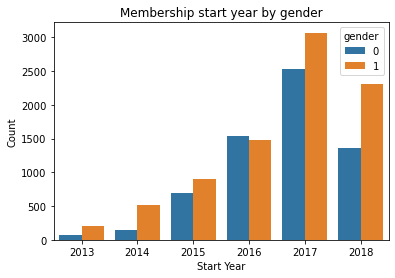

In [88]:
member_df=profile_clean.groupby(['start_year','gender']).size()
member_df=member_df.reset_index()
member_df=member_df.rename(columns={0:'count'})
sns.barplot(x='start_year',y='count',hue='gender',data=member_df)
plt.xlabel('Start Year')
plt.ylabel('Count')
plt.title('Membership start year by gender')


Above shows that most customers(members) joined the starbucks program  2017. Also male member number has been increased in each year.

In [140]:
profile_clean.head()

,gender,age,member_id,became_member_on,income,start_year,start_month
1,0,55.0,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,7
3,0,75.0,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017,5
5,1,68.0,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,2018,4
8,1,65.0,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,2018,2
12,1,58.0,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,2017,11


In [90]:
#calculate event type disribution
event_count=transcript_clean['event'].value_counts()
event_count

transaction        123957
offer received      66501
offer viewed        49860
offer completed     32070
Name: event, dtype: int64

In [91]:
#Calculate percentage of transactions and offers events
total_event=event_count.sum()
print('transaction percentage is',100*event_count[0]/total_event,'offer percentage is ',100*event_count[1:].sum()/total_event)

transaction percentage is 45.507511344112075 offer percentage is  54.492488655887925


#### ◼ Event ditribution by Gender

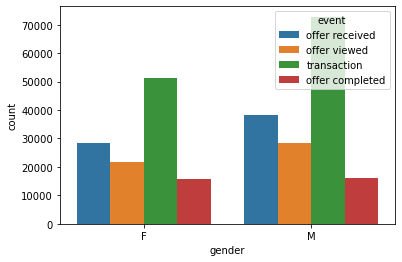

In [92]:
g=sns.countplot(x='gender',hue='event',data=transcript_clean.merge(profile_clean,on='member_id'))
xlabels=gender_mapping
g.set_xticklabels(xlabels)
plt.show()

In [178]:
print(portfolio_transcript.member_id.unique())

['389bc3fa690240e798340f5a15918d5c' 'd1ede868e29245ea91818a903fec04c6'
 '102e9454054946fda62242d2e176fdce' ... '19a0510b9ce24b9da44618f7161ae72d'
 'c3f3b8193c8a4133b8bd0654f82654a1' '54463e5d95124b7fb3133fc1eae71952']


In [ ]:
portfolio_transcript = pd.merge(transcript_clean,portfolio_clean,on='offer_id',how='left')
portfolio_transcript = portfolio_transcript[portfolio_transcript.event != 'offer received']
data = []
ids=(portfolio_transcript.member_id.unique())

offers_viewed = portfolio_transcript[portfolio_transcript.event == 'offer viewed']
offers_completed = portfolio_transcript[portfolio_transcript.event == 'offer completed']
transactions = portfolio_transcript[portfolio_transcript.event == 'transaction']

for i in range(len(ids)):
    
    for index, offer in offers_viewed.iterrows():
        customer_id = offer.member_id
        start_time = offer.time
        end_time = int(start_time + offer.duration)


        if ((transactions.time <= end_time ) & (transactions.time >= start_time)).all():
                transaction_amount= transactions[transactions['member_id'] == customer_id]['amount'].sum()

        if ((offers_completed.time <= end_time )&(offers_completed.time >= start_time )).all():
                if (len(offers_completed[(offers_completed.member_id == customer_id) & 
                                 (offers_completed.offer_id == offer.offer_id) ]))>0 :
                    offer_successfull=1
                else:
                    offer_successfull=0
                    
        customer_offer = {
                    'customer_id': customer_id,
                    'offer_id': offer.offer_id,
                    'start_time': start_time,
                    'difficulty': offer.difficulty,
                    'duration': offer.duration,
                    'web': offer.web,
                    'email': offer.email,
                    'mobile': offer.mobile,
                    'social': offer.social,
                    'transaction_amount': transaction_amount,
                    'offer_successfull': offer_successfull
                }
        offers_df.append(customer_offer)




    data.extend(offers_df)      

    
    
    
    

customer_offers = pd.DataFrame(offers_df)

In [174]:
customer_offers

""
